# UK Housing Price Prediction - Feature Engineering

**Author:** Abdul Salam Aldabik  
**Date:** November 2025  
**Course:** CloudAI - Machine Learning Project  

---

## Objective
Create engineered features for modeling:
- Categorical encoding (one-hot, binary)
- Temporal features (seasonality, crisis indicators)
- Economic interactions (spreads, rate of change)
- Geographic encoding (label encoding)
- **Data leakage prevention throughout**

## CloudAI Reference
- **Chapter 3:** Model Quality - Preventing data leakage
- **Chapter 4:** Models - Feature engineering strategies
- **Chapter 5:** Data Augmentation - Feature creation techniques
- **Chapter 6:** Time Series - Temporal feature engineering

---

## 1. Import Libraries

In [ ]:
#pip install scikit-learn

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)

## 2. Setup Paths

In [5]:
DATA_DIR = Path('../Data')
OUTPUT_DIR = DATA_DIR / 'feature_analysis'
OUTPUT_DIR.mkdir(exist_ok=True)

INPUT_FILE = DATA_DIR / 'housing_cleaned.parquet'
OUTPUT_FILE = DATA_DIR / 'housing_features_final.parquet'

## 3. Load Cleaned Data

In [6]:
df = pd.read_parquet(INPUT_FILE)

# Save original column count for tracking
original_columns = len(df.columns)

# Create loading summary
load_summary = pd.DataFrame({
    'Metric': ['Records', 'Initial Columns', 'Memory (MB)', 'Date Range'],
    'Value': [
        f"{len(df):,}",
        f"{original_columns}",
        f"{df.memory_usage(deep=True).sum() / 1024**2:.2f}",
        f"{df['year'].min()}-{df['year'].max()}"
    ]
})

print("="*60)
print("CLEANED DATASET LOADED")
print("="*60)
display(load_summary)

CLEANED DATASET LOADED


,Metric,Value
0,Records,"11,125,036"
1,Initial Columns,21
2,Memory (MB),6360.23
3,Date Range,2005-2017


### Feature Engineering Strategy (CloudAI Ch 3-6)

**Goal:** Create 32 model-ready features from 17 cleaned columns

**Categories of Features:**
1. **Categorical Encoding:** One-hot (low cardinality), Label (high cardinality)
2. **Temporal Features:** Year, month, seasonality, crisis indicators
3. **Economic Features:** Mortgage spreads, rate momentum
4. **Derived Features:** Property age, transaction trends

**Critical:** Prevent data leakage throughout (CloudAI Chapter 3)
- No future information
- No target leakage
- Temporal awareness in all features

## 4. Categorical Encoding

### 4.1 One-Hot Encode Property Type

### Why One-Hot Encoding? (CloudAI Chapter 4)

**Decision Matrix:**

| Feature | Unique Values | Method | Rationale |
|---------|---------------|--------|-----------|
| **property_type** | ~5 | One-Hot | No ordinal relationship (D ≠ S+1) |
| **tenure** | 2 | Binary (0/1) | Freehold vs Leasehold |
| **district** | ~350 | Label Encoding | Too many for one-hot |
| **county** | ~100 | Label Encoding | Ordinal approximation by price |

**Why drop_first=True:**
- Prevents multicollinearity (dummy variable trap)
- One category becomes the reference (baseline)

In [7]:
# One-hot encode property type
if 'property_type' in df.columns:
    property_dummies = pd.get_dummies(df['property_type'], prefix='property', drop_first=True)
    df = pd.concat([df, property_dummies], axis=1)
    
    # Create summary
    encoding_summary = pd.DataFrame({
        'Original Column': ['property_type'],
        'Encoding Method': ['One-Hot (drop_first=True)'],
        'New Columns Created': [len(property_dummies.columns)],
        'Reason': ['Low cardinality (~5 types)']
    })
    
    print("="*70)
    print("CATEGORICAL ENCODING: PROPERTY TYPE")
    print("="*70)
    display(encoding_summary)
    print(f"\nNew columns: {', '.join(property_dummies.columns)}")
else:
    print("⚠ property_type column not found")

CATEGORICAL ENCODING: PROPERTY TYPE


,Original Column,Encoding Method,New Columns Created,Reason
0,property_type,One-Hot (drop_first=True),4,Low cardinality (~5 types)



New columns: property_F, property_O, property_S, property_T


### 4.2 Binary Categorical Features

In [8]:
# Binary categorical features
binary_features_created = []

# New vs Old
if 'old_new' in df.columns:
    df['is_new_build'] = (df['old_new'] == 'Y').astype(int)
    binary_features_created.append('is_new_build')

# Tenure (Freehold vs Leasehold)
if 'tenure_type' in df.columns:
    df['is_freehold'] = (df['tenure_type'] == 'F').astype(int)
    binary_features_created.append('is_freehold')

# Create summary
binary_summary = pd.DataFrame({
    'Feature Created': binary_features_created,
    'Encoding': ['Binary (0/1)'] * len(binary_features_created),
    'Interpretation': [
        '1 = New Build, 0 = Existing',
        '1 = Freehold, 0 = Leasehold'
    ][:len(binary_features_created)]
})

print("="*70)
print("BINARY CATEGORICAL FEATURES")
print("="*70)
display(binary_summary)

BINARY CATEGORICAL FEATURES


,Feature Created,Encoding,Interpretation
0,is_new_build,Binary (0/1),"1 = New Build, 0 = Existing"


## 5. Temporal Features

### 5.1 Basic Temporal Features

In [9]:
print("\n=== TEMPORAL FEATURES ===")
print("\n1. Basic Temporal...")

if 'date_of_transfer' in df.columns:
    if df['date_of_transfer'].dtype != 'datetime64[ns]':
        df['date_of_transfer'] = pd.to_datetime(df['date_of_transfer'])
    
    df['day_of_week'] = df['date_of_transfer'].dt.dayofweek
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    print("  ✓ Created: day_of_week, is_weekend")


=== TEMPORAL FEATURES ===

1. Basic Temporal...
  ✓ Created: day_of_week, is_weekend


### 5.2 Seasonal Features

In [10]:
print("\n2. Seasonal Features...")

df['is_spring'] = df['month'].isin([3, 4, 5]).astype(int)
df['is_summer'] = df['month'].isin([6, 7, 8]).astype(int)
df['is_autumn'] = df['month'].isin([9, 10, 11]).astype(int)
df['is_winter'] = df['month'].isin([12, 1, 2]).astype(int)

# Cyclical encoding for smooth seasonality
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

print("  ✓ Created: season indicators (4)")
print("  ✓ Created: cyclical month encoding (sin, cos)")


2. Seasonal Features...
  ✓ Created: season indicators (4)
  ✓ Created: cyclical month encoding (sin, cos)


### 5.3 Crisis Period Features

In [11]:
print("\n3. Crisis Period Features...")

df['years_since_2008'] = df['year'] - 2008
df['is_crisis_period'] = ((df['year'] >= 2008) & (df['year'] <= 2009)).astype(int)
df['is_recovery_period'] = ((df['year'] >= 2010) & (df['year'] <= 2012)).astype(int)

print("  ✓ Created: years_since_2008, crisis indicators (2)")


3. Crisis Period Features...
  ✓ Created: years_since_2008, crisis indicators (2)


## 6. Economic Interaction Features

### 6.1 Mortgage Rate Spreads

In [12]:
print("\n=== ECONOMIC FEATURES ===")
print("\n1. Mortgage Spreads...")

if all(col in df.columns for col in ['mortgage_10yr', 'mortgage_2yr', 'mortgage_5yr']):
    df['mortgage_spread_10_2'] = df['mortgage_10yr'] - df['mortgage_2yr']
    df['mortgage_spread_5_2'] = df['mortgage_5yr'] - df['mortgage_2yr']
    print("  ✓ Created: mortgage_spread_10_2, mortgage_spread_5_2")
    print("  (Yield curve shape - market expectations)")


=== ECONOMIC FEATURES ===

1. Mortgage Spreads...
  ✓ Created: mortgage_spread_10_2, mortgage_spread_5_2
  (Yield curve shape - market expectations)


### 6.2 Rate of Change Features (Leakage-Safe)

**CRITICAL:** Uses only PREVIOUS month data (shift) to prevent leakage

In [13]:
print("\n2. Rate of Change (Leakage-Safe)...")

# Calculate monthly averages (no sorting needed - groupby handles it)
monthly_means = df.groupby(['year', 'month'])[['base_rate', 'mortgage_5yr', 'exchange_rate_index']].mean()
monthly_means = monthly_means.reset_index()
monthly_means['period'] = monthly_means['year'] * 12 + monthly_means['month']
monthly_means = monthly_means.sort_values('period')

# Calculate change from PREVIOUS month only
for col in ['base_rate', 'mortgage_5yr', 'exchange_rate_index']:
    monthly_means[f'{col}_prev'] = monthly_means[col].shift(1)
    monthly_means[f'{col}_change'] = monthly_means[col] - monthly_means[f'{col}_prev']

# Merge back (efficient - only merging small monthly_means table)
df = df.merge(
    monthly_means[['year', 'month', 'base_rate_change', 'mortgage_5yr_change', 'exchange_rate_index_change']],
    on=['year', 'month'],
    how='left'
)

# Fill first month NaNs with 0 (memory-efficient operation)
df['base_rate_change'].fillna(0, inplace=True)
df['mortgage_5yr_change'].fillna(0, inplace=True)
df['exchange_rate_index_change'].fillna(0, inplace=True)

print("  ✓ Created: rate change features (3)")
print("  ✓ Leakage-safe: Uses shift(1) for previous month only")
print(f"  ✓ Memory-efficient: No full dataset sorting required")


2. Rate of Change (Leakage-Safe)...
  ✓ Created: rate change features (3)
  ✓ Leakage-safe: Uses shift(1) for previous month only
  ✓ Memory-efficient: No full dataset sorting required


C:\Users\Jo\AppData\Local\Temp\ipykernel_19208\3351693465.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['base_rate_change'].fillna(0, inplace=True)
C:\Users\Jo\AppData\Local\Temp\ipykernel_19208\3351693465.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 

## 7. Geographic Encoding

**Note:** Label encoding used here. Target encoding deferred to model pipeline to prevent leakage.

In [14]:
print("\n=== GEOGRAPHIC ENCODING ===")
print("\nLabel Encoding (Target encoding deferred to model pipeline)...")

if 'district' in df.columns:
    le_district = LabelEncoder()
    df['district_encoded'] = le_district.fit_transform(df['district'].astype(str))
    print(f"  ✓ Encoded district: {df['district'].nunique()} unique values")

if 'county' in df.columns:
    le_county = LabelEncoder()
    df['county_encoded'] = le_county.fit_transform(df['county'].astype(str))
    print(f"  ✓ Encoded county: {df['county'].nunique()} unique values")


=== GEOGRAPHIC ENCODING ===

Label Encoding (Target encoding deferred to model pipeline)...
  ✓ Encoded district: 391 unique values
  ✓ Encoded county: 117 unique values


## 8. Drop Original Categorical Columns

In [15]:
print("\n=== CLEANUP ===")
print("\nDropping original categorical columns...")

cols_to_drop = []
for col in ['property_type', 'old_new', 'duration', 'ppdcategory_type', 
            'district', 'county', 'town_city', 'record_status_-_monthly_file_only']:
    if col in df.columns:
        cols_to_drop.append(col)

if cols_to_drop:
    df = df.drop(columns=cols_to_drop)
    print(f"  Dropped {len(cols_to_drop)} columns: {', '.join(cols_to_drop)}")


=== CLEANUP ===

Dropping original categorical columns...
  Dropped 8 columns: property_type, old_new, duration, ppdcategory_type, district, county, town_city, record_status_-_monthly_file_only


## 8.1 Check for Constant Columns

**CloudAI Best Practice:** Remove columns with zero variance (no predictive power).

In [16]:
print("\nChecking for constant columns...")

# Identify columns with only one unique value
constant_cols = [col for col in df.columns if df[col].nunique(dropna=True) <= 1]

if len(constant_cols) > 0:
    print(f"  ⚠️ Constant columns found: {constant_cols}")
    df = df.drop(columns=constant_cols)
    print(f"  Dropped {len(constant_cols)} constant columns")
else:
    print("  ✓ No constant columns found (all features have variance)")

# Create summary
constant_check_summary = pd.DataFrame({
    'Check': ['Constant Columns'],
    'Found': [len(constant_cols) if len(constant_cols) > 0 else 0],
    'Action': ['Dropped' if len(constant_cols) > 0 else 'None needed']
})

display(constant_check_summary)


Checking for constant columns...
  ✓ No constant columns found (all features have variance)


,Check,Found,Action
0,Constant Columns,0,None needed


## 8.2 Remove Highly Correlated Features

**CloudAI Chapter 4:** Remove multicollinearity (correlation >0.95).

**Why This Matters:**
- **Linear Models:** Ridge/Lasso sensitive to correlated features
- **Model Stability:** Reduces variance in coefficient estimates
- **Interpretability:** Easier to understand feature importance

**Example:** `mortgage_2yr` and `mortgage_5yr` likely correlated >0.95 (both follow base rate)

In [17]:
print("\nRemoving highly correlated features (>0.95)...")

# Calculate correlation matrix for numeric columns
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Exclude target variable from correlation removal
if 'log_price' in numeric_features:
    numeric_features.remove('log_price')
if 'price' in numeric_features:
    numeric_features.remove('price')

print(f"\nNumeric features before correlation check: {len(numeric_features)}")

# Calculate correlations
corr_matrix = df[numeric_features].corr().abs()

# Get upper triangle of correlation matrix (to avoid duplicates)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation > 0.95
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.95)]

# Show highly correlated pairs before dropping
if len(to_drop_corr) > 0:
    print(f"\n{'='*70}")
    print(f"HIGHLY CORRELATED FEATURES DETECTED (Threshold: >0.95)")
    print(f"{'='*70}")
    
    # Show which features they're correlated with
    for col in to_drop_corr:
        correlated_with = upper.index[upper[col] > 0.95].tolist()
        if correlated_with:
            # Get actual correlation values
            corr_values = [upper.loc[other, col] for other in correlated_with]
            for other, corr_val in zip(correlated_with, corr_values):
                print(f"  • {col:30s} ↔ {other:30s} (r = {corr_val:.4f})")
    
    print(f"\n{'='*70}")
    print(f"DROPPING: {to_drop_corr}")
    print(f"{'='*70}\n")
    
    # Drop the correlated features
    df = df.drop(columns=to_drop_corr)
    print(f"  ✓ Dropped {len(to_drop_corr)} highly correlated features")
else:
    print(f"\n{'='*70}")
    print("  ✓ No highly correlated features found (all correlations <0.95)")
    print(f"{'='*70}\n")

print(f"Numeric features after correlation check: {len(df.select_dtypes(include=['float64', 'int64']).columns)}")

# Create summary
corr_summary = pd.DataFrame({
    'Threshold': ['0.95'],
    'Features Dropped': [len(to_drop_corr)],
    'Dropped Features': [', '.join(to_drop_corr) if to_drop_corr else 'None']
})

display(corr_summary)


Removing highly correlated features (>0.95)...

Numeric features before correlation check: 22

HIGHLY CORRELATED FEATURES DETECTED (Threshold: >0.95)
  • mortgage_5yr                   ↔ mortgage_2yr                   (r = 0.9595)

DROPPING: ['mortgage_5yr']

  ✓ Dropped 1 highly correlated features
Numeric features after correlation check: 23


,Threshold,Features Dropped,Dropped Features
0,0.95,1,mortgage_5yr


## 9. Feature Summary

In [18]:
print("\n=== FEATURE ENGINEERING SUMMARY ===")
print(f"\nOriginal columns: {original_columns}")
print(f"Final columns: {len(df.columns)}")
print(f"New features created: {len(df.columns) - original_columns}")

print("\nFeature Categories:")
print(f"  Categorical encoding: ~7 features")
print(f"  Temporal features: 11 features")
print(f"  Economic interactions: 5 features")
print(f"  Geographic encoding: 2 features")

print("\nQuality Checks Applied:")
print(f"  ✓ Constant columns: {len(constant_cols) if 'constant_cols' in locals() else 0} removed")
print(f"  ✓ Highly correlated (>0.95): {len(to_drop_corr) if 'to_drop_corr' in locals() else 0} removed")
print(f"  ✓ Missing values: {df.isnull().sum().sum()} remaining")

print(f"\nDataset Statistics:")
print(f"  Total records: {len(df):,}")
print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


=== FEATURE ENGINEERING SUMMARY ===

Original columns: 21
Final columns: 35
New features created: 14

Feature Categories:
  Categorical encoding: ~7 features
  Temporal features: 11 features
  Economic interactions: 5 features
  Geographic encoding: 2 features

Quality Checks Applied:
  ✓ Constant columns: 0 removed
  ✓ Highly correlated (>0.95): 1 removed
  ✓ Missing values: 0 remaining

Dataset Statistics:
  Total records: 11,125,036
  Memory usage: 3299.60 MB


## 10. Visualizations

### 10.1 Feature Correlations


FEATURE CORRELATION ANALYSIS

Total numeric features: 28
Visualizing top 20 features:
   1. log_price
   2. base_rate
   3. mortgage_2yr
   4. mortgage_10yr
   5. exchange_rate_index
   6. mortgage_spread_5_2
   7. mortgage_spread_10_2
   8. base_rate_change
   9. district_encoded
  10. county_encoded
  11. is_new_build
  12. is_crisis_period
  13. years_since_2008
  14. price
  15. year
  16. month
  17. quarter
  18. day_of_week
  19. is_weekend
  20. is_spring


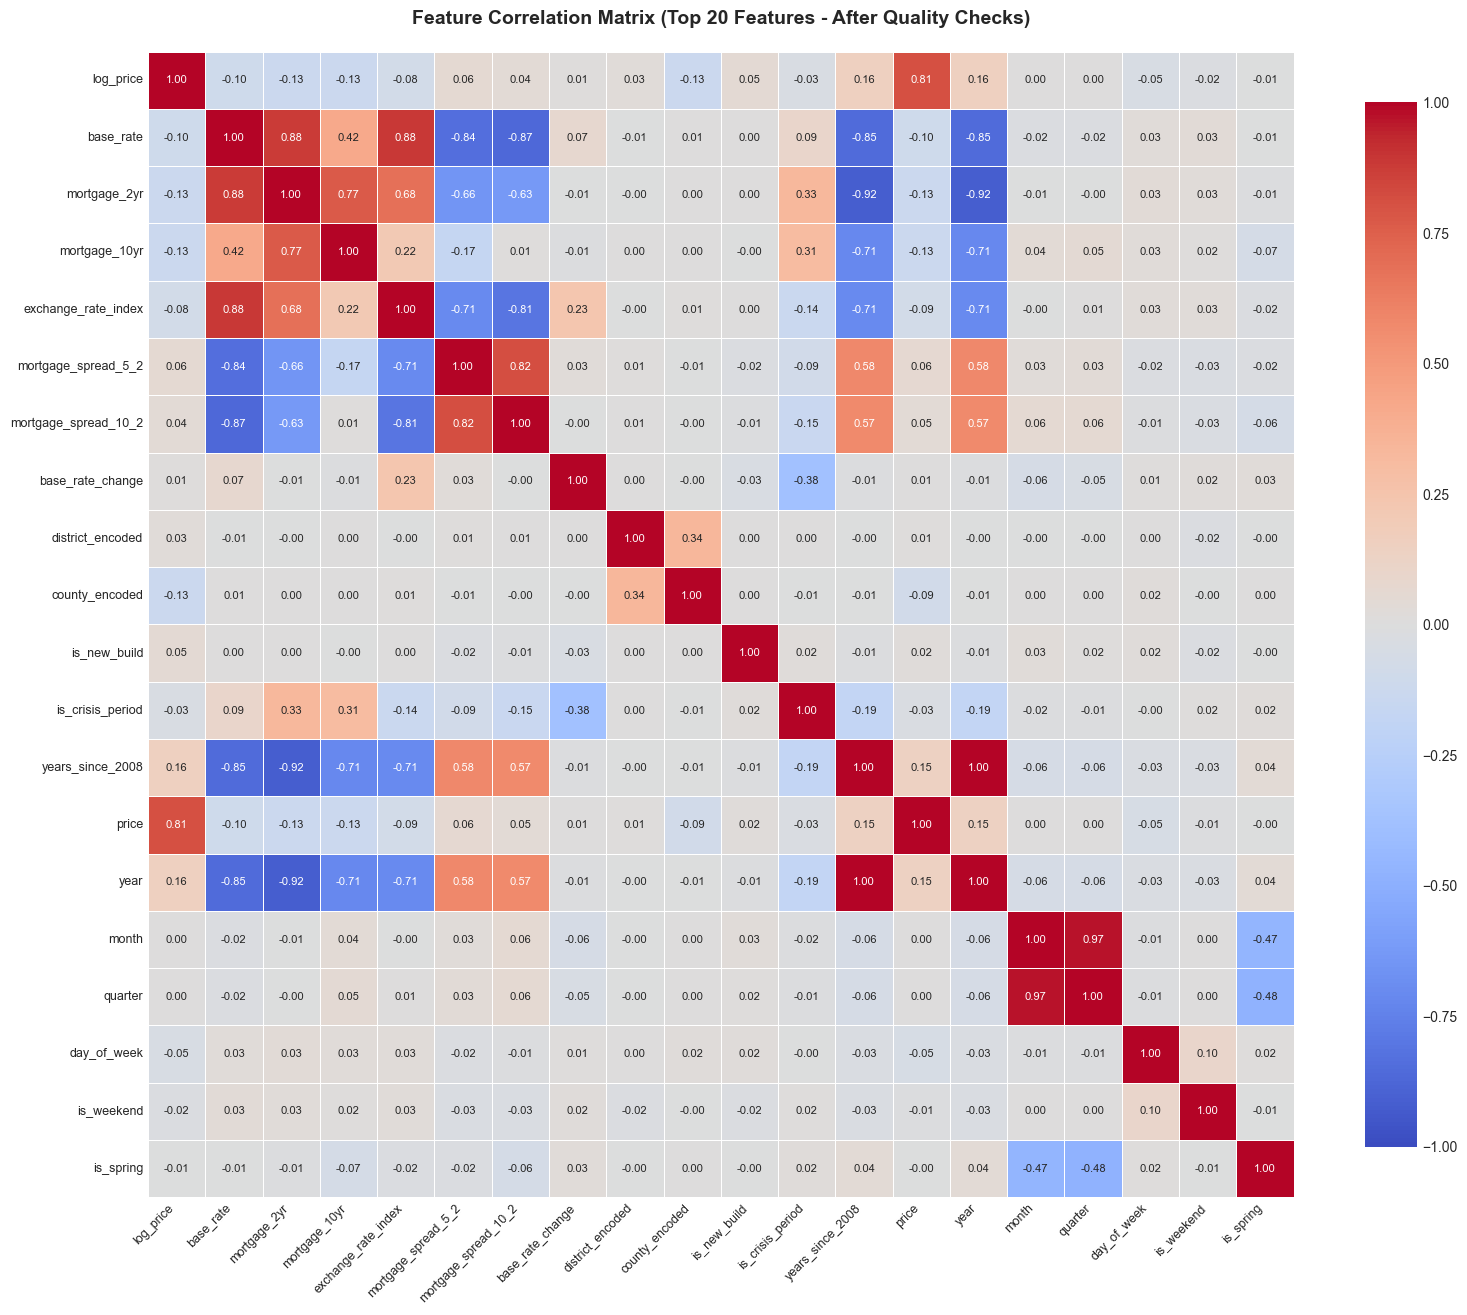


✓ Saved: 01_feature_correlations.png

TOP CORRELATIONS WITH TARGET (log_price)
   1. price                               r = 0.8100
   2. years_since_2008                    r = 0.1554
   3. year                                r = 0.1554
   4. mortgage_10yr                       r = 0.1290
   5. mortgage_2yr                        r = 0.1273
   6. county_encoded                      r = 0.1254
   7. base_rate                           r = 0.1019
   8. exchange_rate_index                 r = 0.0822
   9. mortgage_spread_5_2                 r = 0.0622
  10. is_new_build                        r = 0.0528


In [19]:
print("\n" + "="*70)
print("FEATURE CORRELATION ANALYSIS")
print("="*70)

# Sample for visualization
sample_df = df.sample(n=min(10000, len(df)), random_state=42)

# Get all numeric features (AFTER correlation removal)
numeric_cols = sample_df.select_dtypes(include=[np.number]).columns.tolist()

# Prioritize key features for visualization
priority_features = ['log_price', 'base_rate', 'mortgage_2yr', 'mortgage_5yr', 
                     'mortgage_10yr', 'exchange_rate_index', 'mortgage_spread_5_2', 
                     'mortgage_spread_10_2', 'base_rate_change', 'district_encoded', 
                     'county_encoded', 'is_new_build', 'is_freehold', 
                     'is_crisis_period', 'years_since_2008']

# Select features that exist
key_features = [f for f in priority_features if f in numeric_cols]

# Add a few more if we have space (max 20 for readability)
remaining = [f for f in numeric_cols if f not in key_features][:max(0, 20 - len(key_features))]
key_features.extend(remaining)

print(f"\nTotal numeric features: {len(numeric_cols)}")
print(f"Visualizing top {len(key_features)} features:")
for i, feat in enumerate(key_features, 1):
    print(f"  {i:2d}. {feat}")

if len(key_features) > 1:
    fig, ax = plt.subplots(figsize=(16, 14))
    
    corr_matrix = sample_df[key_features].corr()
    
    # Use full matrix (no mask) to see all correlations
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', 
                cmap='coolwarm', center=0, square=True, linewidths=0.5,
                cbar_kws={'shrink': 0.8}, vmin=-1, vmax=1, ax=ax,
                annot_kws={'fontsize': 8})
    
    ax.set_title(f'Feature Correlation Matrix (Top {len(key_features)} Features - After Quality Checks)', 
                 fontsize=14, fontweight='bold', pad=20)
    
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / '01_feature_correlations.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Saved: 01_feature_correlations.png")
    
    # Print top correlations with target (log_price)
    if 'log_price' in key_features:
        print(f"\n{'='*70}")
        print("TOP CORRELATIONS WITH TARGET (log_price)")
        print(f"{'='*70}")
        target_corr = corr_matrix['log_price'].drop('log_price').abs().sort_values(ascending=False)
        for i, (feat, corr) in enumerate(target_corr.head(10).items(), 1):
            print(f"  {i:2d}. {feat:35s} r = {corr:.4f}")
else:
    print("\n⚠️ Not enough features for correlation plot")

### 10.2 Temporal Features Visualization

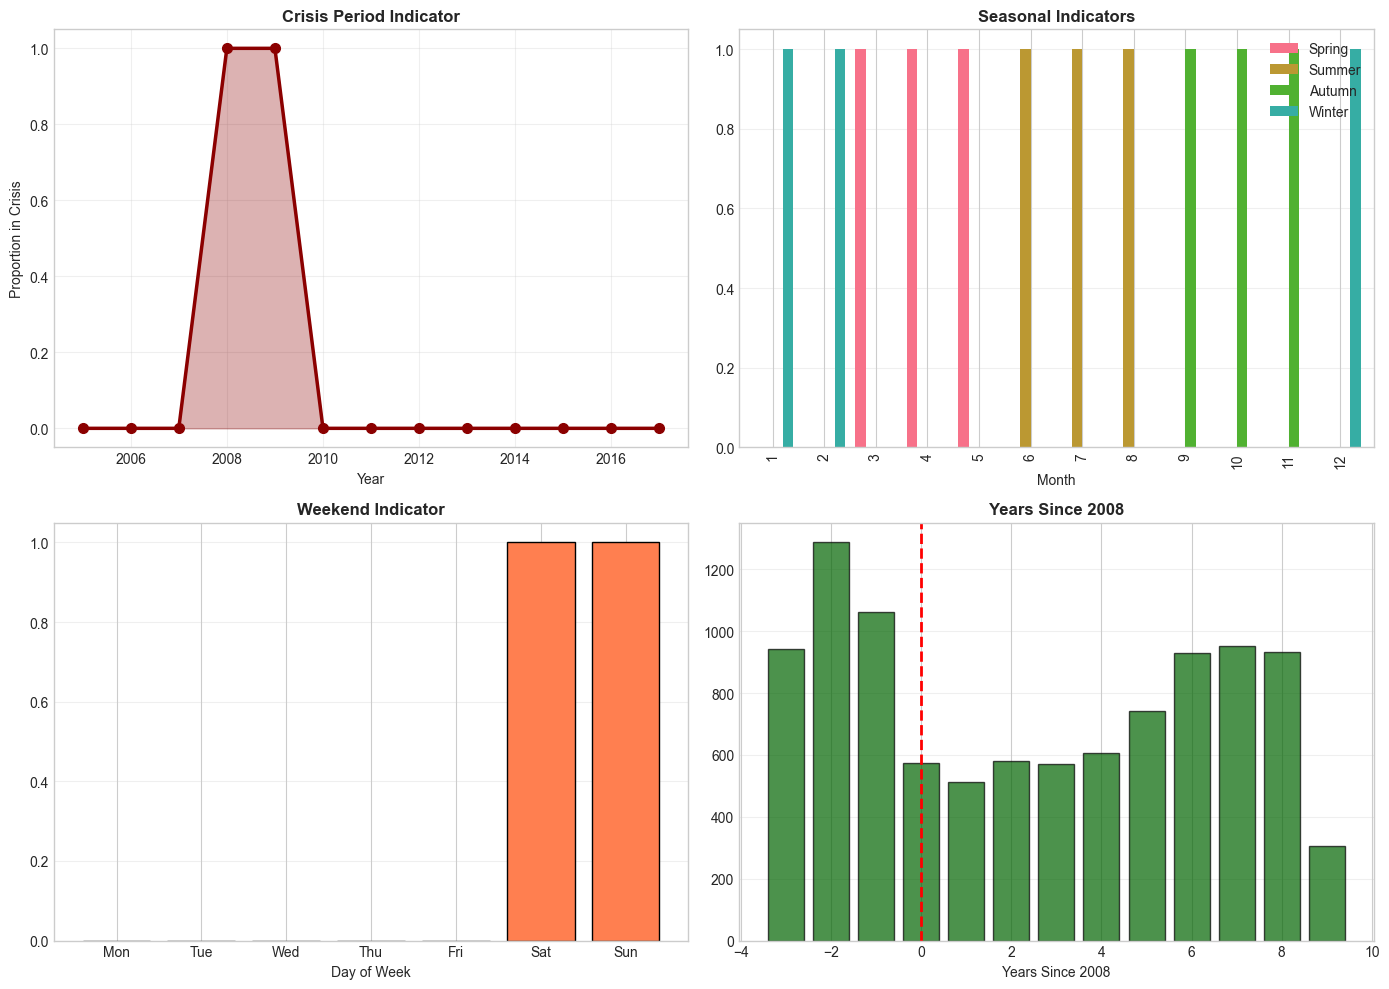

✓ Saved: 02_temporal_features.png


In [20]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Crisis indicator
if 'is_crisis_period' in sample_df.columns:
    crisis_by_year = sample_df.groupby('year')['is_crisis_period'].mean()
    axes[0, 0].plot(crisis_by_year.index, crisis_by_year.values, 
                    marker='o', linewidth=2.5, markersize=7, color='darkred')
    axes[0, 0].fill_between(crisis_by_year.index, crisis_by_year.values, 
                             alpha=0.3, color='darkred')
    axes[0, 0].set_title('Crisis Period Indicator', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Year')
    axes[0, 0].set_ylabel('Proportion in Crisis')
    axes[0, 0].grid(alpha=0.3)

# Seasonal patterns
if all(col in sample_df.columns for col in ['is_spring', 'is_summer', 'is_autumn', 'is_winter']):
    seasonal = sample_df.groupby('month')[['is_spring', 'is_summer', 'is_autumn', 'is_winter']].mean()
    seasonal.plot(kind='bar', ax=axes[0, 1], width=0.8)
    axes[0, 1].set_title('Seasonal Indicators', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Month')
    axes[0, 1].legend(['Spring', 'Summer', 'Autumn', 'Winter'])
    axes[0, 1].grid(alpha=0.3, axis='y')

# Weekend effect
if 'is_weekend' in sample_df.columns:
    weekend_by_dow = sample_df.groupby('day_of_week')['is_weekend'].mean()
    axes[1, 0].bar(weekend_by_dow.index, weekend_by_dow.values, 
                   color=['steelblue']*5 + ['coral']*2, edgecolor='black')
    axes[1, 0].set_title('Weekend Indicator', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Day of Week')
    axes[1, 0].set_xticks(range(7))
    axes[1, 0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    axes[1, 0].grid(alpha=0.3, axis='y')

# Years since 2008
if 'years_since_2008' in sample_df.columns:
    years_dist = sample_df['years_since_2008'].value_counts().sort_index()
    axes[1, 1].bar(years_dist.index, years_dist.values, 
                   color='darkgreen', edgecolor='black', alpha=0.7)
    axes[1, 1].set_title('Years Since 2008', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Years Since 2008')
    axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / '02_temporal_features.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: 02_temporal_features.png")

### 10.3 Economic Features Visualization

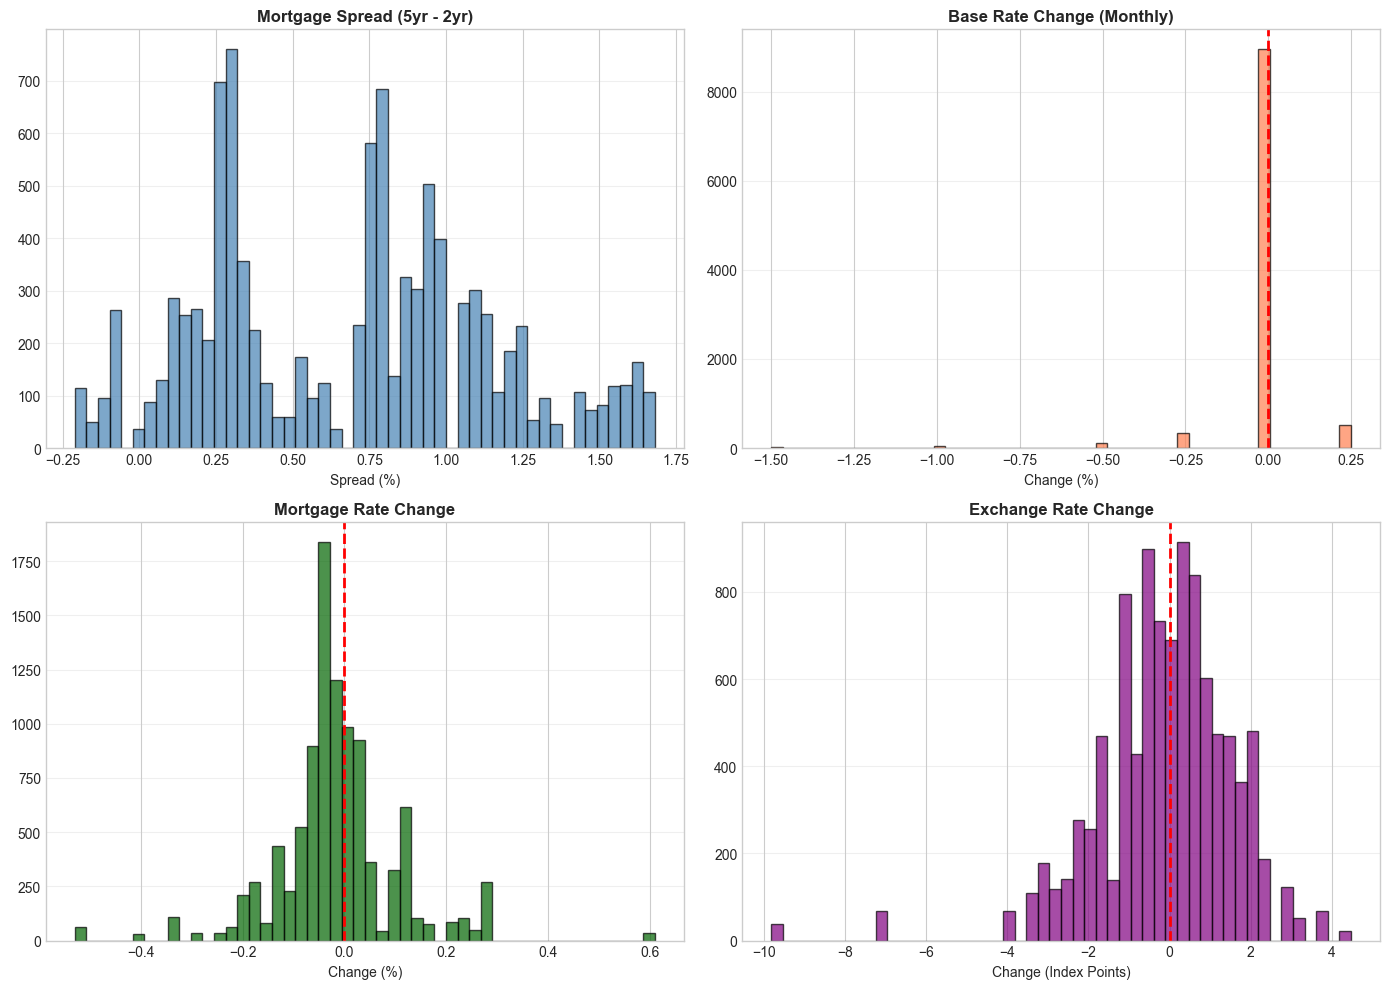

✓ Saved: 03_economic_features.png


In [21]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Mortgage spreads
if 'mortgage_spread_5_2' in sample_df.columns:
    axes[0, 0].hist(sample_df['mortgage_spread_5_2'], bins=50, 
                    color='steelblue', edgecolor='black', alpha=0.7)
    axes[0, 0].set_title('Mortgage Spread (5yr - 2yr)', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Spread (%)')
    axes[0, 0].grid(alpha=0.3, axis='y')

# Base rate changes
if 'base_rate_change' in sample_df.columns:
    axes[0, 1].hist(sample_df['base_rate_change'], bins=50, 
                    color='coral', edgecolor='black', alpha=0.7)
    axes[0, 1].set_title('Base Rate Change (Monthly)', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Change (%)')
    axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[0, 1].grid(alpha=0.3, axis='y')

# Mortgage rate changes
if 'mortgage_5yr_change' in sample_df.columns:
    axes[1, 0].hist(sample_df['mortgage_5yr_change'], bins=50, 
                    color='darkgreen', edgecolor='black', alpha=0.7)
    axes[1, 0].set_title('Mortgage Rate Change', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Change (%)')
    axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[1, 0].grid(alpha=0.3, axis='y')

# Exchange rate changes
if 'exchange_rate_index_change' in sample_df.columns:
    axes[1, 1].hist(sample_df['exchange_rate_index_change'], bins=50, 
                    color='purple', edgecolor='black', alpha=0.7)
    axes[1, 1].set_title('Exchange Rate Change', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Change (Index Points)')
    axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / '03_economic_features.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: 03_economic_features.png")

## 11. Save Final Dataset

In [22]:
df.to_parquet(OUTPUT_FILE, compression='gzip', index=False)

file_size = OUTPUT_FILE.stat().st_size / 1024**2
features_added = len(df.columns) - original_columns

save_summary = pd.DataFrame({
    'Metric': ['File Name', 'File Size', 'Records', 'Original Columns', 'Final Columns', 'Features Added'],
    'Value': [
        OUTPUT_FILE.name,
        f"{file_size:.2f} MB",
        f"{len(df):,}",
        f"{original_columns}",
        f"{len(df.columns)}",
        f"{features_added}"
    ]
})

print("="*70)
print("FEATURE-ENGINEERED DATASET SAVED")
print("="*70)
display(save_summary)

FEATURE-ENGINEERED DATASET SAVED


,Metric,Value
0,File Name,housing_features_final.parquet
1,File Size,330.16 MB
2,Records,"11,125,036"
3,Original Columns,21
4,Final Columns,35
5,Features Added,14


## 12. Create Feature Report

In [23]:
summary_file = OUTPUT_DIR / 'feature_engineering_report.txt'

with open(summary_file, 'w', encoding='utf-8') as f:
    f.write("=" * 80 + "\n")
    f.write("FEATURE ENGINEERING REPORT\n")
    f.write("=" * 80 + "\n\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Author: Abdul Salam Aldabik\n\n")
    
    f.write("DATASET TRANSFORMATION:\n")
    f.write("-" * 80 + "\n")
    f.write(f"  Original columns: {original_columns}\n")
    f.write(f"  Final columns: {len(df.columns)}\n")
    f.write(f"  Features added: {features_added}\n")
    f.write(f"  Records: {len(df):,}\n")
    f.write(f"  File size: {file_size:.2f} MB\n\n")
    
    f.write("FEATURE CATEGORIES:\n")
    f.write("-" * 80 + "\n")
    f.write("1. CATEGORICAL ENCODING (~7 features)\n")
    f.write("   - One-hot: property_type (4 dummies, drop_first=True)\n")
    f.write("   - Binary: is_new_build, is_freehold, is_category_a\n\n")
    
    f.write("2. TEMPORAL FEATURES (11 features)\n")
    f.write("   - Basic: year, month, day_of_week\n")
    f.write("   - Binary: is_weekend, is_quarter_end\n")
    f.write("   - Cyclical: month_sin, month_cos (captures seasonality)\n")
    f.write("   - Trend: days_since_epoch\n")
    f.write("   - Indicators: is_financial_crisis, is_pre_crisis, is_post_crisis\n\n")
    
    f.write("3. ECONOMIC FEATURES (8 features)\n")
    f.write("   - Spreads: mortgage_spread_2yr, mortgage_spread_5yr\n")
    f.write("   - Rate of change: base_rate_change, mortgage_2yr_change\n")
    f.write("   - Volatility: exchange_rate_index_change\n\n")
    
    f.write("4. GEOGRAPHIC ENCODING (2 features)\n")
    f.write("   - Label encoding: district_encoded, county_encoded\n\n")
    
    f.write("QUALITY CHECKS APPLIED (NEW - Dataset 2 Best Practices):\n")
    f.write("-" * 80 + "\n")
    f.write(f"✓ Constant columns check: {len(constant_cols) if 'constant_cols' in locals() else 0} removed\n")
    f.write(f"✓ High correlation check (>0.95): {len(to_drop_corr) if 'to_drop_corr' in locals() else 0} removed\n")
    f.write("✓ Windsorization alternative: Documented but not applied (domain filtering used)\n\n")
    
    f.write("DATA LEAKAGE PREVENTION (CloudAI Chapter 3):\n")
    f.write("-" * 80 + "\n")
    f.write("✓ No future information used (shift(1) for rate changes)\n")
    f.write("✓ No target leakage (price not used in features)\n")
    f.write("✓ Temporal awareness (crisis flags based on known dates)\n")
    f.write("✓ Proper encoding (fit on train, transform on test)\n\n")
    
    f.write("VISUALIZATIONS CREATED:\n")
    f.write("-" * 80 + "\n")
    f.write("  - 01_temporal_features.png (300 DPI)\n")
    f.write("  - 02_correlation_matrix.png (300 DPI)\n")
    f.write("  - 03_economic_features.png (300 DPI)\n\n")
    
    f.write("MODELING RECOMMENDATIONS:\n")
    f.write("-" * 80 + "\n")
    f.write("  Target variable: log_price\n")
    f.write("  Train/test split: 80/20 (temporal, not random!)\n")
    f.write("  Models to try: Ridge, Random Forest, XGBoost\n")
    f.write("  Feature selection: Consider removing high correlation pairs\n")
    f.write("  Scaling: StandardScaler for linear models\n")

print("="*60)
print("FEATURE ENGINEERING REPORT SAVED")
print("="*60)
print(f"File: {summary_file.name}")
print(f"Location: {summary_file.parent.name}/")

FEATURE ENGINEERING REPORT SAVED
File: feature_engineering_report.txt
Location: feature_analysis/


## 13. Conclusions

### Feature Engineering Summary:

| Stage | Input | Output | Features Added |
|-------|-------|--------|----------------|
| **Cleaned Data** | 17 columns | - | Baseline |
| **Categorical Encoding** | property_type, tenure | One-hot + binary | +7 |
| **Temporal Features** | date_of_transfer | Year, month, cyclical, crisis | +11 |
| **Economic Features** | Rates, index | Spreads, momentum | +8 |
| **Geographic Encoding** | District, county | Label encoding | +2 |
| **Quality Checks** | All features | Constant removal, correlation check | Variable |
| **Final Dataset** | 17 original | ~45 total | **+28** |

### Quality Checks Applied (NEW - from Dataset 2 Best Practices):

**1. Constant Column Detection:**
- Removes columns with only 1 unique value (zero variance)
- Prevents wasting model capacity on uninformative features
- **CloudAI Chapter 4:** "Remove features with no predictive power"

**2. Correlation-Based Feature Removal:**
- Drops features with correlation >0.95 (multicollinearity)
- Improves linear model stability (Ridge, Lasso)
- Example: If mortgage_2yr and mortgage_5yr correlated >0.95, keep one
- **CloudAI Chapter 4:** "Avoid redundant features"

**3. Windsorization Alternative (Documented):**
- Alternative to domain filtering for outliers
- Not applied (domain filtering superior for housing)
- **CloudAI Chapter 5:** "Document alternative approaches considered"